# FWI modelo personalizado

In [3]:
using PyPlot, JLD, SegyIO, JUDI, SlimOptim, Statistics, Random, LinearAlgebra, ImageFiltering, HDF5

In [4]:
# Load starting model
n,d,o,m0 = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "n", "d", "o", "m0")
model0 = Model((n[1],n[2]), (d[1],d[2]), (o[1],o[2]), m0)

Model (n=(401, 121), d=(25.0f0, 25.0f0), o=(0.0f0, 0.0f0)) with parameters [:m]


In [16]:
mm = read(h5open("$(JUDI.JUDI_DATA)/overthrust_model.h5","r"), "m")
v = sqrt.(1f0 ./ mm);

In [8]:
# Bound constraints
v0 = sqrt.(1f0 ./ m0)
vmin = ones(Float32, model0.n) .* 1.3f0
vmax = ones(Float32, model0.n) .* 6.5f0
vmin[:,1:21] .= v0[:,1:21]   # keep water column fixed
vmax[:,1:21] .= v0[:,1:21];
# Slowness squared [s^2/km^2]
mmin = vec((1f0 ./ vmax).^2)
mmax = vec((1f0 ./ vmin).^2);

In [7]:
# Load data
block = segy_read("model_overthrust_low_f.segy")
d_obs = judiVector(block)

┌ Warning: Fixed length trace flag set in stream: IOBuffer(data=UInt8[...], readable=true, writable=false, seekable=true, append=false, size=7220304, maxsize=Inf, ptr=3601, mark=-1)
└ @ SegyIO /home/geouser/.julia/packages/SegyIO/aQwou/src/read/read_file.jl:36


judiVector{Float32, Matrix{Float32}} with 16 sources


In [9]:
# Set up wavelet
srcGeometry = Geometry(block; key="source")	# read source position geometry
wavelet = ricker_wavelet(srcGeometry.t[1], srcGeometry.dt[1], 0.004f0)	# 4 Hz wavelet
q = judiVector(srcGeometry, wavelet)

judiVector{Float32, Matrix{Float32}} with 16 sources


In [10]:
F0 = judiModeling(deepcopy(model0), srcGeometry, d_obs.geometry)

JUDI forward{Float32} propagator (src * rec * time) -> (src * rec * time)


In [11]:
# Optimization parameters
niterations = parse(Int, get(ENV, "NITER", "30"))
batchsize = 16
fhistory_SGD = zeros(Float32, niterations);
m0_values = zeros(length(model0.m), niterations);

In [12]:
# Projection operator for bound constraints
proj(x) = reshape(median([vec(mmin) vec(x) vec(mmax)]; dims=2),model0.n)
ls = BackTracking(order=3, iterations=10, );

In [13]:
# Main loop
for j=1:niterations

    # get fwi objective function value and gradient
    i = randperm(d_obs.nsrc)[1:batchsize]
    fval, gradient = fwi_objective(model0, q[i], d_obs[i])
    p = -gradient/norm(gradient, Inf)
    
    println("FWI iteration no: ",j,"; function value: ",fval)
    fhistory_SGD[j] = fval

    # linesearch
    function ϕ(α)
        F0.model.m .= proj(model0.m .+ α * p)
        misfit = .5*norm(F0[i]*q[i] - d_obs[i])^2
        @show α, misfit
        return misfit
    end
    step, fval = ls(ϕ, 1f-1, fval, dot(gradient, p))

    # Update model and bound projection
    model0.m .= proj(model0.m .+ step .* p)
    m0_values[:, j] = model0.m
end

FWI iteration no: 1; function value: 721802.44
(α, misfit) = 

Building forward operator
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/geouser/.local/lib/python3.9/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Operator `forward` ran in 0.04 s
Building adjoint born operator
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 

(0.1f0, 910540.1875)


Building forward operator
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.04742700516854659, 223900.765625)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


2; function value: 237669.2


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 2.48531825e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.025088084813932196, 336982.21875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.009899615000365163, 130418.1953125)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


3; function value: 144179.19


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.313850125e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.022741740870195648, 101733.7109375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s


FWI iteration no: 4; function value: 115622.29
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 2.10040125e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.024392309457638248, 431695.90625)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.006357777440286211, 55535.3671875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


FWI iteration no: 5; function value: 69395.12
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.08 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 427530.59375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.025453382951319922, 51400.3515625)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s


6; function value: 65322.977


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.55134325e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s


(0.022957953860972272, 381602.59375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.004744695940363873, 29601.978515625)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


7; function value: 43502.566


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 397991.96875)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(0.021150563209983486, 34920.046875)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


FWI iteration no: 8; function value: 48859.336
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.602762e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.020363352892543787, 310922.6875)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.004054544766775466, 19341.005859375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


FWI iteration no: 9; function value: 33257.52
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 410074.6875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.019100374549537925, 26921.56640625)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s


10; function value: 40864.316


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.576798125e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.019409889770600076, 289806.6875)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.003692053707193776, 13767.857421875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


11; function value: 27690.258


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 420225.5625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.01772864826451301, 23111.775390625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s


FWI iteration no: 12; function value: 37064.664
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.520988625e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.018889096201452307, 247047.4375)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.0037518134266096236, 12403.501953125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


FWI iteration no: 13; function value: 30742.484
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 418372.78125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


(α, misfit) = (0.018428151264150983, 20295.255859375)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


14; function value: 40229.113


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.584585875e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s


(0.017530410258131904, 187790.0)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.00394456323576631, 7370.24365234375)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


15; function value: 25398.803


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 767122.5625)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.011688976846003275, 22157.0546875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s


FWI iteration no: 16; function value: 40583.957
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.44946675e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.017726298095617772, 156957.578125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.004362528954238242, 6512.81494140625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 17; function value: 24522.674
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.19161025e6)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.010000000149011612, 16957.751953125)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


18; function value: 34927.664


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.568133375e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s


(0.016011841167556124, 130469.8359375)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.004036612748567362, 5826.8876953125)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s


19; function value: 23821.521


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.07 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.043985875e6)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.010000000149011612, 29164.11328125)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.003965685388490876, 7018.947265625)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


20; function value: 25011.697


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.409520875e6)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s


(0.01157637255355607, 87768.0703125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.002349585035554577, 5471.99267578125)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


21; function value: 23484.965


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.445182875e6)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s


(0.010000000149011612, 32225.458984375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.003712768533287845, 6912.53466796875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


22; function value: 24904.518


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.5439175e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.012005121788269082, 136593.203125)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.0018799661948282588, 4926.8740234375)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s


23; function value: 22918.105


Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.155506875e6)
(α, misfit) = 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(0.010000000149011612, 22443.1875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


FWI iteration no: 24; function value: 40384.355
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.48839625e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.02099173086856081, 304288.0)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.05 s


(0.004170312767345619, 4195.64306640625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 25; function value: 22185.705
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 292511.0625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.017072814424318437, 11409.30078125)
FWI iteration no: 

Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s


26; function value: 29380.469


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.621904e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.06 s


(0.015711927703938325, 194651.359375)


Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


(α, misfit) = (0.002906480882354426, 3759.581787109375)
FWI iteration no: 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s


27; function value: 21749.947


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 786701.8125)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s


(0.010000000149011612, 15691.6630859375)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s


FWI iteration no: 28; function value: 33652.355
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.09 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 1.36539225e6)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(α, misfit) = (0.018377994122395696, 200719.125)
(α, misfit) = 

Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


(0.0037730064503459144, 3453.21826171875)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s


FWI iteration no: 29; function value: 21444.672
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(0.1f0, 543704.625)


Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s


(α, misfit) = (0.010594527183411159, 7899.33154296875)
FWI iteration no: 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s


30; function value: 25868.121


Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `gradient` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `gradient` ran in 0.

(α, misfit) = (0.1f0, 1.591685e6)
(α, misfit) = 

Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.04 s


(0.012063967925524324, 78244.5)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.07 s
Operator `forward` ran in 0.05 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s


(α, misfit) = (0.003032449688886237, 3809.79150390625)


Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.04 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.03 s
Operator `forward` ran in 0.06 s
Operator `forward` ran in 0.07 s


In [19]:
fwi = sqrt.(1f0./adjoint(reshape(m0_values[:, 29], (401,121))));

In [23]:
maximum(v)

5.5f0

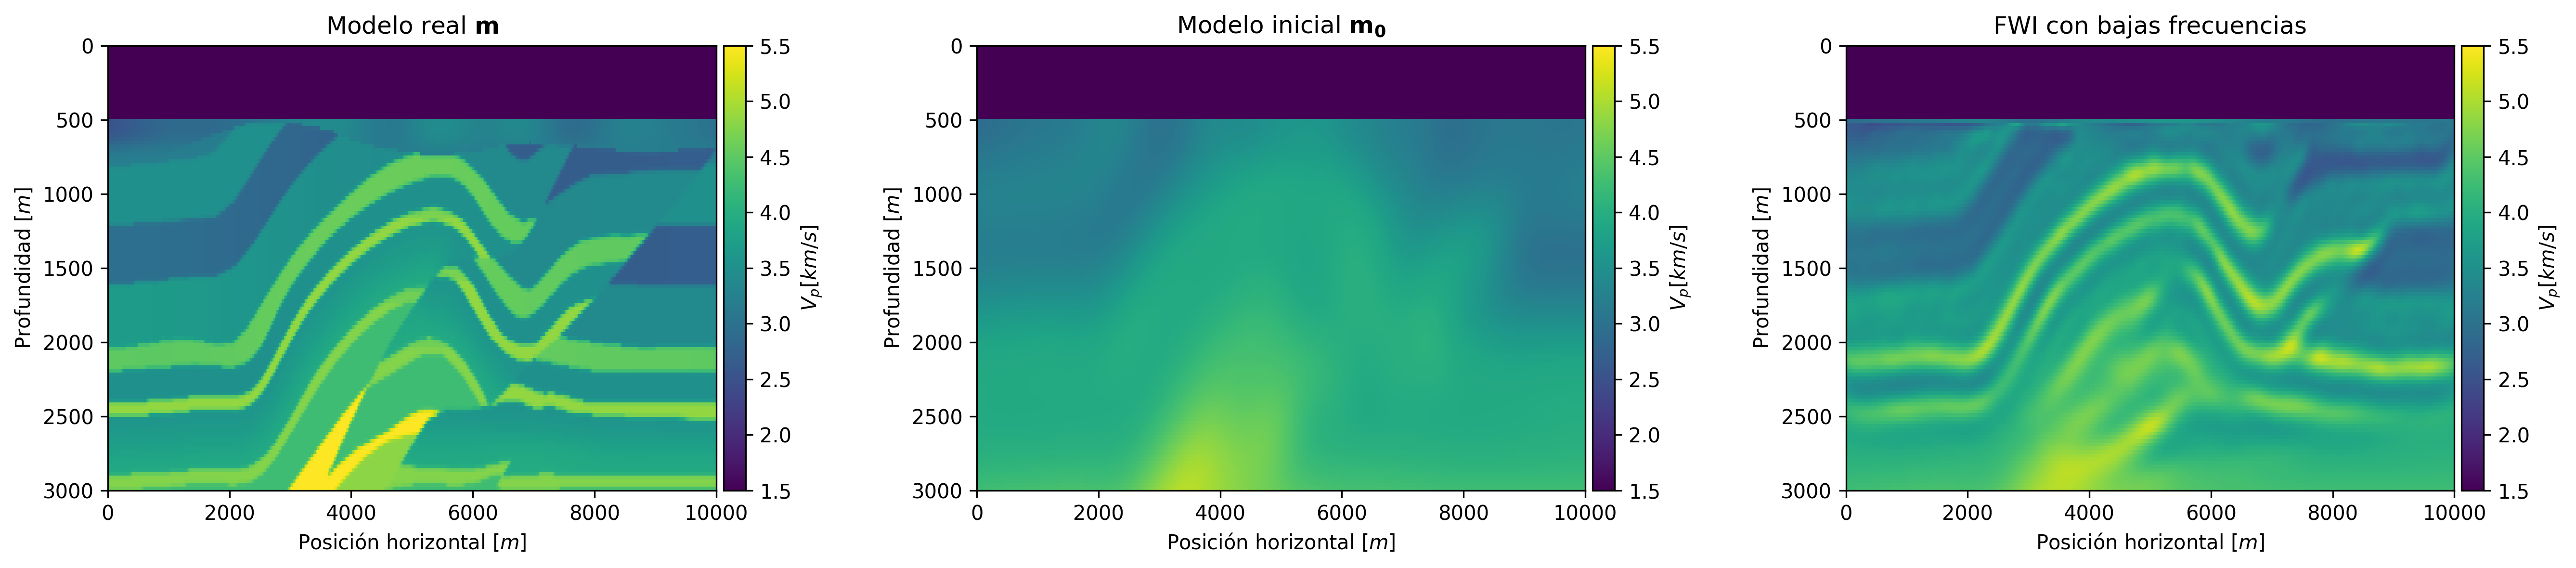

In [28]:
fig=figure(figsize=(22,4), dpi=300);
subplot(131)
im = imshow(v', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo real $\mathbf{m}$")
subplot(132)
im = imshow(v0', cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title(L"Modelo inicial $\mathbf{m_0}$")
subplot(133)
im = imshow(fwi, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=1.5, vmax=5.5, aspect="auto")
cb = colorbar(im, pad=0.01)
cb[:set_label](label = L"$V_p [km/s]$")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("FWI con bajas frecuencias")
display(fig)

In [30]:
mse = sum((v .- v0).^2) / length(v)
println("El error cuadrático medio del modelo inicial es: ", mse)
mse = sum((v .- fwi').^2) / length(v)
println("El error cuadrático medio de FWI es: ", mse)

El error cuadrático medio del modelo inicial es: 0.1265017
El error cuadrático medio de FWI es: 

0.05322190362027793


In [31]:
error_porcentaje_v0 = 100 * sum(abs.(v - v0)) / sum(abs.(v))
error_porcentaje_fwi = 100 * sum(abs.(v - fwi')) / sum(abs.(v))

println("Porcentaje de error (v0): ", error_porcentaje_v0)
println("Porcentaje de error (FWI): ", error_porcentaje_fwi)

Porcentaje de error (v0): 7.9860744
Porcentaje de error (FWI): 4.489374036920178


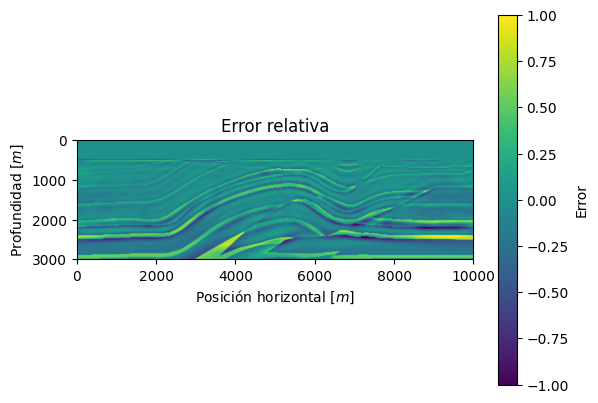

In [34]:
difs = v'-fwi
fig=figure() #figsize=(20, 5)
im = imshow(difs, cmap="viridis", extent=[0, (model0.n[1]-1)*model0.d[1], (model0.n[2]-1)*model0.d[2], 0], vmin=-1, vmax=1)
cb = colorbar(im)
cb[:set_label](label = "Error")
xlabel(L"Posición horizontal $[m]$")
ylabel(L"Profundidad $[m]$")
title("Error relativa")
display(fig)

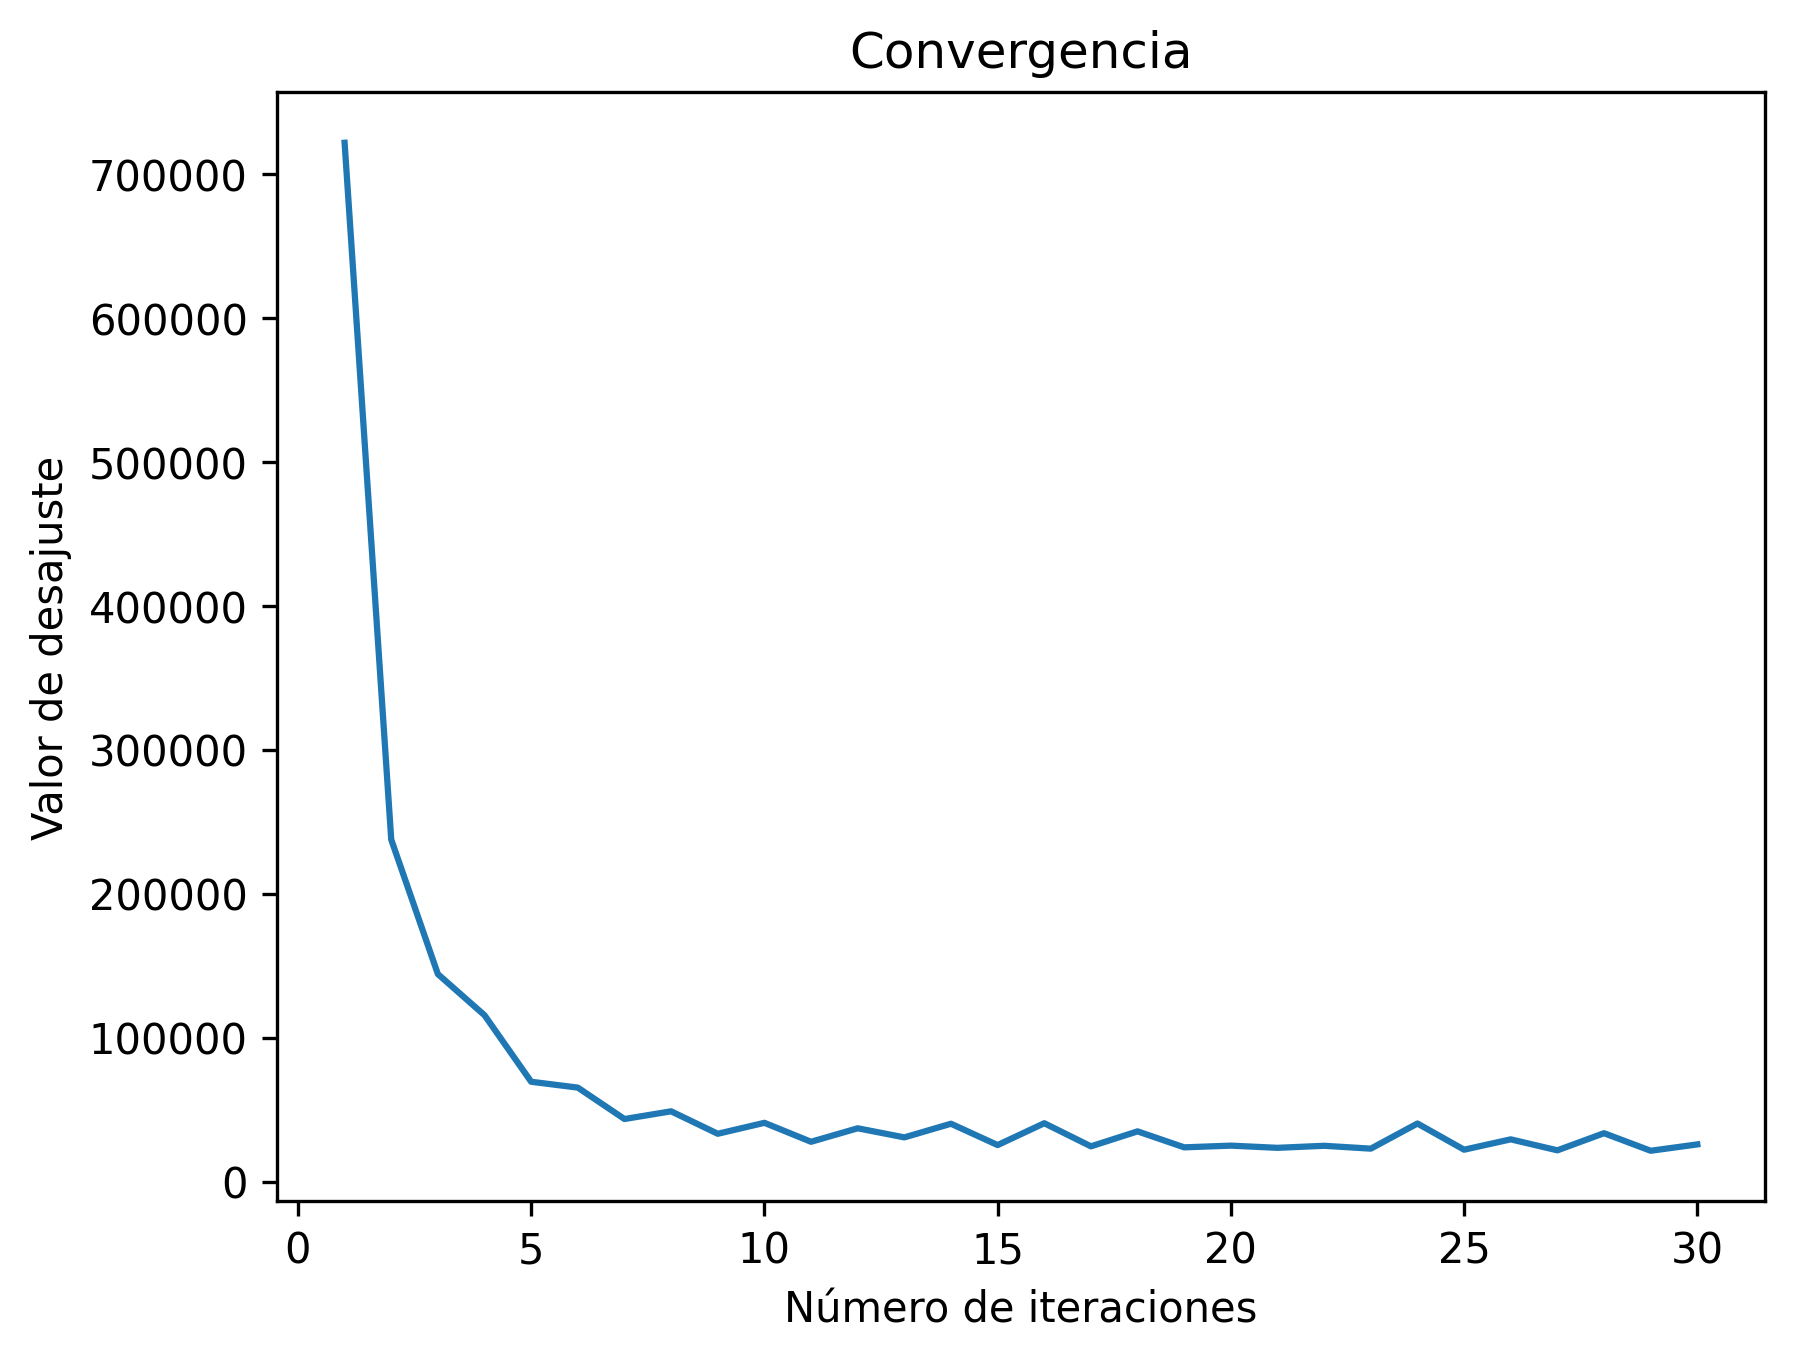

In [35]:
fig=figure(dpi=300) #figsize=(20, 5)
xax = 1:1:30
plot(xax, fhistory_SGD)
xlabel("Número de iteraciones")
ylabel("Valor de desajuste")
title("Convergencia")
display(fig)

In [42]:
dm = mm - m0;

In [43]:
save("model_overthrust_fwi_result_low_f.jld", "n", n, "d", d, "o", o, "m", mm, "m0", model0.m.data, "dm", dm, "fwi", fwi')